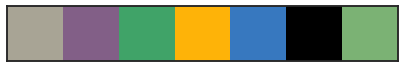

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf
from pprint import pprint
import re as re

from statsmodels.regression.mixed_linear_model import MixedLMResults

import scipy as sp
#from scipy.stats import nanmean
#from scipy.stats import nanstd
import copy
import scipy.stats as stats
import string

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pprint import pprint
import seaborn as sns
sns.set(style="white", context="talk")
custom_palette = [ "greyish", "dusty purple", "greenish", "amber", "windows blue", "black","faded green"]  
                     #"green blue", "dull green", "faded green",  
sns.set_palette(sns.xkcd_palette(custom_palette))
current_palette = sns.color_palette()
%matplotlib inline
sns.palplot(current_palette)

import warnings
warnings.filterwarnings('ignore')


## Import data

In [2]:
game_rounds = pd.read_csv('./all_studies_game_data.csv')
conditions = ['dynamic_full_feedback',
              'dynamic',         
              'dynamic_self_feedback',
              'dynamic_no_feedback',
              'static',
              'solo_feedback',
              'solo_no_feedback'
             ]


colors ={'dynamic_no_feedback':'#196FFF',
         'dynamic_self_feedback':'#000000',
         'dynamic_full_feedback':'#81B200',
         'dynamic': '#81B200',
         'static':'#9B59B6',
         'solo_feedback': '#95A5A6',
         'solo_no_feedback': '#95A5A6'
        }


linestyles ={'dynamic_no_feedback':'-.',
         'dynamic_self_feedback':':',
         'dynamic_full_feedback':'-',
         'dynamic': '-',
         'static':'--',
         'solo_feedback': '-',
         'solo_no_feedback': '-'
        }

markers ={'dynamic_no_feedback':'d',
         'dynamic_self_feedback':'^',
         'dynamic_full_feedback':'o',
         'dynamic': 'o',
         'static':'*',
         'solo_feedback': 'H',
         'solo_no_feedback': 'h'
        }

#markers = ['s','o','*']
#linestyles = ['--','-',':','-.']
tick_size = 25
label_size = 35




studies = [1,2]


In [3]:
# la buena
# outcome variables:  avg(error)  ,   std(error)    
# statistics:        only  avg[ ...  ]   ,  std[ ... ]   --> for error bars
# unit of analysis:  game = >    avg_{games}[  avg_{rounds}(error)   ] ;
    #                            avg_{games}[  std_{rounds}(error)   ] ;

    
    
    
def boot_condition_top_k_means_and_stds(b, condition, ks, wk_stats_boot, games_df, gids_condition, rids): 
    
    ### make frame with repeated IDs;    
    size = min(len(gids_condition), 20)                 # size = # games of condition, or 20
    b_gids = np.random.choice(  gids_condition  , size= size, replace= True )
    df_list = []
    for i, gid in enumerate(b_gids):                                
        bools = (games_df.condition == condition) & (games_df.game_id == gid) & (games_df.round_index.isin(rids))  # temporary for dealing with both frames
        games_df['boot_id'] =  np.where( bools , i , games_df['boot_id'] )     # track repeated gids
        df_list.append(  games_df[ bools ]  )    
    games_sample_df = pd.concat(df_list, ignore_index=True) 

    ### compute statistics for each k
    for k in ks:                                                        
        col = "top_"+str(k)+'_rev_live';  means = []; stds = []
        for i, gid in enumerate(b_gids): 
            bools = (games_sample_df.game_id==gid) & (games_sample_df.boot_id == i)
            means.append( np.nanmean( games_sample_df[bools][col] ) )   # game average across rounds
            stds.append(  np.nanstd ( games_sample_df[bools][col] ) )   # game variance across rounds

        wk_stats_boot [condition][k][0].append( np.nanmean( means ) )   #  avg (game avgs.)
        wk_stats_boot [condition][k][1].append( np.nanmean( stds  ) )   #  avg (game stds.) 


    
    
def wk_stats_CIs_and_SEs_2019(conds, df, n_boot = 100, rids = list(range(1,20+1))):
    
    np.random.seed(seed=0)
    
    games_df = df.copy(deep=True); games_df['boot_id'] = None;
    ks = list( range(1, 12 +1 ) )  
    #wk_stats_boot =   {'solo_feedback': [[],], 'static': [[],], 'dynamic': [[],] }
    wk_stats_boot = {}
    for condition in conds:   wk_stats_boot[condition] = [ [], ]

    for condition in conditions:
        
        top_k_errors = {}
        gids_condition = games_df[games_df.condition == condition].game_id.unique() # ids of the condition
        for k in ks:   wk_stats_boot[condition].append( [ [] , [] ] )
            
        print(condition)

        for b in range(0, n_boot):
            print("Boot        ", b, "  ", end='\r')
            boot_condition_top_k_means_and_stds(b, condition, ks, wk_stats_boot, games_df, gids_condition, rids)  #**           

    
    ################ mean estimates and confidence intervals ############## 
    low_p = 2.5              # 95% CIs
    up_p  = 97.5
    
    # make dicts to save results
    wk_stats, wk_cierrs, wk_SEs = {}, {}, {}
    for condition in conds:   
        wk_stats[condition] = [ [], ]; wk_cierrs[condition] = [ [], ]; wk_SEs[condition] = [ [], ]

    # compute them
    for condition in conditions:
        for k in ks:  
            wk_stats [condition].append([ [],[] ])            # means per objective 
            wk_cierrs [condition].append([ [],[],[],[] ])     # CIs per objective
            wk_SEs [condition].append([ [],[] ])              # SEs per objective
            means = wk_stats_boot[condition][k][0]            # bootstraped vectors
            stds  = wk_stats_boot[condition][k][1]

            wk_stats[condition][k][0] = np.mean( means )                          # mean of sampling dist.
            wk_stats[condition][k][1] = np.mean( stds )                           # mean of sampling dist.
            wk_SEs  [condition][k][0] = np.std( means )                           # std of sampling dist.
            wk_SEs  [condition][k][1] = np.std( stds )                            # std of sampling dist.
            wk_cierrs[condition][k][0] = abs( np.mean( means ) -  np.percentile( means , low_p ) )    # ci low bound
            wk_cierrs[condition][k][1] = abs( np.mean( means ) -  np.percentile( means , up_p ) )     # ci up bound
            wk_cierrs[condition][k][2] = abs( np.mean( stds ) -   np.percentile( stds ,  low_p ) ) 
            wk_cierrs[condition][k][3] = abs( np.mean( stds ) -   np.percentile( stds ,  up_p ) ) 
    #wk_cierrs['static'][1]
 
    #pprint(wk_stats); pprint(wk_cierrs); pprint(wk_SEs)


    ####### bootstraped p-values on selected comparissons: ################
    if True:
        wdn_vs_solok1_mean =    np.asarray(wk_stats_boot['dynamic'][12][0] ) -  np.asarray( wk_stats_boot['solo_feedback'][1][0])
        wdn_vs_solok1_std =     np.asarray(wk_stats_boot['dynamic'][12][1] ) -  np.asarray( wk_stats_boot['solo_feedback'][1][1])
        dynk1_vs_solok1_mean =  np.asarray(wk_stats_boot['dynamic'][1] [0] )  -  np.asarray( wk_stats_boot['solo_feedback'][1][0])
        dynk1_vs_solok1_std =   np.asarray(wk_stats_boot['dynamic'][1] [1] )  -  np.asarray( wk_stats_boot['solo_feedback'][1][1])


        # prints
        print ( "sum(wdn_vs_solok1_mean < 0)/ n_boot", sum(wdn_vs_solok1_mean < 0)/ n_boot)
        print ( "sum(wdn_vs_solok1_std < 0)/ n_boot",  sum(wdn_vs_solok1_std  < 0)/ n_boot)
        print ( "sum(dynk1_vs_solok1_mean < 0)/ n_boot", sum(dynk1_vs_solok1_mean < 0)/ n_boot)
        print ( "sum(dynk1_vs_solok1_std < 0)/ n_boot",  sum(dynk1_vs_solok1_std  < 0)/ n_boot)
        print ( "std of dyn-top-12 improves solo-top-1 by (%): ", np.mean( np.asarray(wk_stats_boot['dynamic'][12][1] ) )  / 
                np.mean( np.asarray( wk_stats_boot['solo_feedback'] [1] [1] ) ) - 1 )
        print ( "std of dyn-top-1 improves solo-top-1 by (%): ", np.mean( np.asarray(wk_stats_boot['dynamic'][1][1] ) )  / 
                np.mean( np.asarray( wk_stats_boot['solo_feedback']  [1] [1] ) ) - 1  )
        print ( "mean of dyn-top-12 improves solo-top-1 by (%): ", np.mean( np.asarray(wk_stats_boot['dynamic'][12][0] ) )  / 
                np.mean( np.asarray( wk_stats_boot['solo_feedback'] [1] [0] ) ) - 1 )
        print ( "mean of dyn-top-1 improves solo-top-1 by (%): ", np.mean( np.asarray(wk_stats_boot['dynamic'][1][0] ) )  / 
                np.mean( np.asarray( wk_stats_boot['solo_feedback']  [1] [0] ) ) - 1  )

    
    return wk_stats , wk_cierrs, wk_SEs



In [4]:
conditions = [
    'solo_feedback',
    'solo_no_feedback',
    'static',
    'dynamic_self_feedback',
    'dynamic_no_feedback',
    'dynamic',
    'dynamic_full_feedback',
]



n_boot = 500                                  # number of bootstrap cycles
bars_type = 'CIs'                              # type of error bars to plot: CIs or SEs
rids2= list(range(6,10+1)) + list(range(16,20+1))  # subset of rounds
#rids2 = range(1,20+1)
for i, rids in enumerate([rids2]):           # [rids0, rids1]):
   
    wk_stats , wk_cierrs, wk_SEs = wk_stats_CIs_and_SEs_2019( conditions, game_rounds , n_boot = n_boot, rids= rids)
    
#     tradeoff_plot_2019(conditions, wk_stats , wk_cierrs, bars=bars_type, wk_SEs=wk_SEs, 
#                   save=False, full=True, suffix='v2-b'+str(n_boot)+bars_type, markers=markers,colors=colors)


solo_feedback
solo_no_feedback   
static       499   
dynamic_self_feedback
dynamic_no_feedback
dynamic      499   
dynamic_full_feedback
sum(wdn_vs_solok1_mean < 0)/ n_boot 0.984
sum(wdn_vs_solok1_std < 0)/ n_boot 1.0
sum(dynk1_vs_solok1_mean < 0)/ n_boot 0.994
sum(dynk1_vs_solok1_std < 0)/ n_boot 0.968
std of dyn-top-12 improves solo-top-1 by (%):  -0.386630651427053
std of dyn-top-1 improves solo-top-1 by (%):  -0.27074166208023953
mean of dyn-top-12 improves solo-top-1 by (%):  -0.16392541205649147
mean of dyn-top-1 improves solo-top-1 by (%):  -0.2389386467248854


In [5]:

def tradeoff_plot_2019(conditions, wk_stats , wk_cierrs, ks= list(range(1, 12+1)), 
                       bars='CIs', wk_SEs=None,
                       save=False, full=False , suffix='v', 
                       kks=[3,6,9], kkks=[1,12], annot=False,
                       msize = 75,  ansep=.001, 
                       colors = ['darkkhaki', "purple", 'yellowgreen', 'teal', 'darkorange', "olive", "blue", "mediumseagreen" ],
                       markers = ['o', '^', 's', 'o', '^', 's', 'o', '^', 's']):
    
    
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111)

#     color_list = [ "greyish", "dusty purple", "greenish", "amber", "windows blue", "black","faded green"]
#     color_list = ['darkkhaki', "purple", 'yellowgreen', 'teal', 'darkorange', "olive", "blue", "mediumseagreen" ]
#     #color_list = [ "purple", 'yellowgreen', 'teal', 'darkkhaki', 'darkorange', "olive", "blue", "mediumseagreen" ]
    color_list = colors

    wis_names = ['wisdom '+cond for cond in conditions]

    
    for i, condition in enumerate(conditions):
        k_means = [wk_stats[condition][k][0] for k in ks ]
        k_stds =  [wk_stats[condition][k][1] for k in ks ]
        

        if annot: 
            for j, k in enumerate(ks):
                ax.annotate( str(k), xy=( k_means[j], k_stds[j] ) , fontsize= 8,
                            xytext=( np.array(k_means[j]) +ansep, np.array(k_stds[j]) +ansep) )
        
        if  True:
            for kk in kks:  
                ax.scatter(wk_stats[condition][kk][0], wk_stats[condition][kk][1], \
                   s= msize, alpha= .7 ,  marker= markers[i], edgecolor='black', linewidth='.2',
                   c = color_list[i]) 
 
        
        if True:
            for kkk in kkks:
                
                ax.scatter(wk_stats[condition][kkk][0], wk_stats[condition][kkk][1], \
                   s= msize, alpha= .93 , label= wis_names[i], marker=markers[i] , edgecolor='black', linewidth='.8',
                   c = color_list[i], zorder=1) 
                
                if bars:
                    plt.errorbar(wk_stats[condition][kkk][0], wk_stats[condition][kkk][1], 
                                 markersize = .1 , fmt = 'o', alpha = .1 , color= color_list[i],
                                 xerr= [ [wk_cierrs[condition][kkk][0] ], [wk_cierrs[condition][kkk][1] ] ] ,
                                 yerr= [ [wk_cierrs[condition][kkk][2] ], [wk_cierrs[condition][kkk][3] ] ]  )
                
                ax.annotate( str(kkk), xy=( k_means[kkk-1], k_stds[kkk-1] ) , fontsize= 8,
                                xytext=( np.array(k_means[kkk-1]) +ansep, np.array(k_stds[kkk-1]) +ansep),
                           zorder=1)

        


    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

    ax.tick_params(labelsize=30)
    ax.set_xlim(0.049,0.201)
    ax.set_ylim(0.049,0.15)

    ax.set_xlabel("Average absolute error",fontsize=35)
    ax.set_ylabel("Variability [standard deviation]", fontsize=35)
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=3)#, bbox_to_anchor=(0., -0.02, 1., -0.102), mode='expand' )

    #plt.colorbar()
    
    if save: plt.savefig(suffix+'.pdf', 
                          dpi=200, bbox_inches='tight', format = 'pdf')
    plt.show()
    


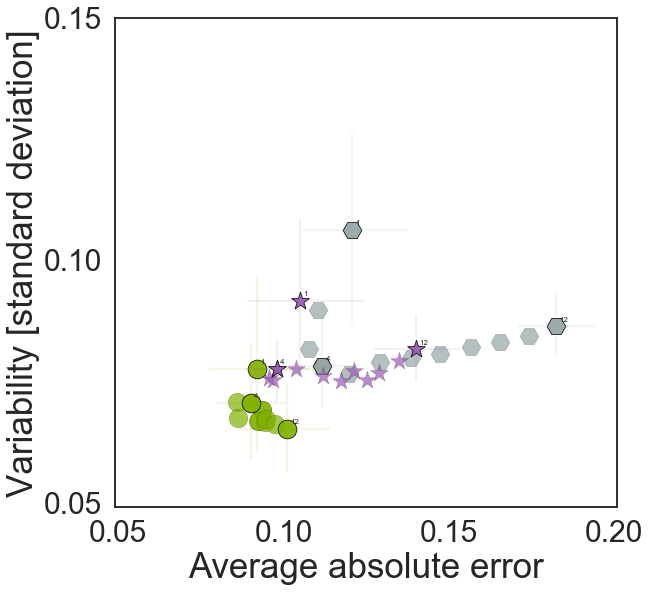

In [9]:
#study 1


conditions = [
    'solo_feedback',
    #'solo_no_feedback',
    'static',
    #'dynamic_self_feedback',
    #'dynamic_no_feedback',
    'dynamic',
    #'dynamic_full_feedback',
    #'dynamic_full_feedback_s12',
]


colors =['#95A5A6',
         #'#3D797A',
         '#9B59B6',
         #'#000000',
         #'#196FFF',
         '#81B200',
        ]

markers =['H',
          #'h',
          '*',
          'o']


tradeoff_plot_2019(
    conditions= conditions,
    wk_stats=wk_stats,
    wk_cierrs=wk_cierrs,
    ks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    bars='CIs',
    wk_SEs=wk_SEs,
    save=False,
    full=True,
    suffix='study1_rev_live_true',
    kks=[2,3,4,5,6,7,8,9,10,11], #[4, 9], #without error bars
    kkks=[1,4,12], #with error bars
    annot=False,
    msize=350,
    ansep=0.001,
    colors=colors,
    markers=markers,
)

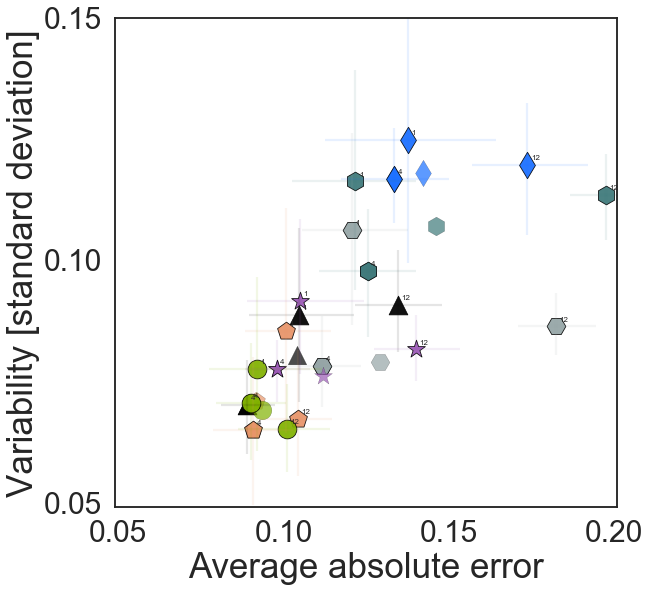

In [10]:
#All together
conditions = ['dynamic_full_feedback',
              'dynamic',         
              'dynamic_self_feedback',
              'dynamic_no_feedback',
              'static',
              'solo_feedback',
              'solo_no_feedback'
             ]


colors ={'dynamic_no_feedback':'#196FFF',
         'dynamic_self_feedback':'#000000',
         'dynamic_full_feedback':'#81B200',
         'dynamic': '#81B200',
         'static':'#9B59B6',
         'solo_feedback': '#95A5A6',
         'solo_no_feedback': '#95A5A6'
        }



markers ={'dynamic_no_feedback':'d',
         'dynamic_self_feedback':'^',
         'dynamic_full_feedback':'o',
         'dynamic': 'o',
         'static':'*',
         'solo_feedback': 'H',
         'solo_no_feedback': 'h'
        }


conditions = [
    'solo_no_feedback',
    'dynamic_self_feedback',
    'dynamic_no_feedback',
    'dynamic_full_feedback',
    'solo_feedback',
    'static',
    'dynamic'
    
    
]


colors =['#3D797A',
         '#000000',
         '#196FFF',
         '#E89468',
         '#95A5A6',
         '#9B59B6',
         '#81B200'
         
        ]

markers =['h',
          '^',
          'd',
          'p',
          "H",
          '*',
          'o'
         ]


tradeoff_plot_2019(
    conditions= conditions,
    wk_stats=wk_stats,
    wk_cierrs=wk_cierrs,
    ks=[1,2,3,4,5,6,7,8, 9,10,11,12],
    bars='CIs',
    wk_SEs=wk_SEs,
    save=False,
    full=True,
    suffix='both_rev_live',
    kks=[4,6], #[4, 9], #without error bars
    kkks=[1, 4, 12], #with error bars
    annot=False,
    msize=350,
    ansep=0.001,
    colors=colors,
    markers=markers,
)